# Qubitization Phase Estimation

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `QubitizationQPE`
Heisenberg limited phase estimation circuit for learning eigenphase of `walk`.

The Bloq yields an OPTREE to construct Heisenberg limited phase estimation circuit
for learning eigenphases of the `walk` operator with `m` bits of accuracy. The
circuit is implemented as given in Fig.2 of Ref-1.

```
       ┌─────────┐                                     ┌─────────┐
  |0> -│         │-------------------------(0)---(0)---│         │---M--- [m1]:highest bit
       │         │                          |     |    │         │
  |0> -│         │----------------(0)---(0)-+-----+----│         │---M--- [m2]
       │CtrlState│                 |     |  |     |    │ QFT_inv │
  |0> -│  Prep   │-------(0)---(0)-+-----+--+-----+----│         │---M--- [m3]
       │         │        |     |  |     |  |     |    │         │
  |0> -│         │---@----+-----+--+-----+--+-----+----│         │---M--- [m4]:lowest bit
       └─────────┘   |    |     |  |     |  |     |    └─────────┘
|Psi> ---------------W----R-W^2-R--R-W^4-R--R-W^8-R---------------------- |Psi>
```

TODO: Note that there are slight differences between the Fig2 of the Ref[1] and the circuit
      implemented here. Further investigation is required to reconcile the difference.

#### Parameters
 - `walk`: Bloq representing the Qubitization walk operator to run the phase estimation protocol on.
 - `m_bits`: Bitsize of the phase register to be used during phase estimation.
 - `ctrl_state_prep`: Bloq to prepare the control state on the phase register. Defaults to `OnEach(self.m_bits, Hadamard())`.
 - `qft_inv`: Bloq to apply inverse QFT on the phase register. Defaults to `QFTTextBook(self.m_bits).adjoint()`  

#### Registers
 - `qpe_reg`: Control register of type `QFxp(self.m_bits, self.m_bits)` for phase estimation.
 - `target registers`: All registers used in `self.unitary.signature` 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Fig. 2


In [2]:
from qualtran.bloqs.phase_estimation.qubitization_qpe import QubitizationQPE

### Example Instances

In [3]:
import numpy as np

from qualtran.bloqs.hubbard_model import get_walk_operator_for_hubbard_model
from qualtran.bloqs.phase_estimation import QubitizationQPE

x_dim, y_dim, t = 2, 2, 2
mu = 4 * t
walk = get_walk_operator_for_hubbard_model(x_dim, y_dim, t, mu)

algo_eps = t / 100
N = x_dim * y_dim * 2
qlambda = 2 * N * t + (N * mu) // 2
qpe_eps = algo_eps / (qlambda * np.sqrt(2))
qubitization_qpe_hubbard_model_small = QubitizationQPE.from_standard_deviation_eps(
    walk, qpe_eps
)

In [4]:
import numpy as np

from qualtran.bloqs.chemistry.sparse.prepare_test import build_random_test_integrals
from qualtran.bloqs.chemistry.sparse.walk_operator import get_walk_operator_for_sparse_chem_ham
from qualtran.bloqs.phase_estimation import QubitizationQPE

num_spatial = 6
tpq, eris = build_random_test_integrals(num_spatial // 2)
walk = get_walk_operator_for_sparse_chem_ham(
    tpq, eris, num_bits_rot_aa=8, num_bits_state_prep=16
)

algo_eps = 0.0016
qlambda = np.sum(np.abs(tpq)) + 0.5 * np.sum(np.abs(eris))
qpe_eps = algo_eps / (qlambda * np.sqrt(2))
qubitization_qpe_sparse_chem = QubitizationQPE.from_standard_deviation_eps(walk, qpe_eps)

In [5]:
from openfermion.resource_estimates.utils import QI

from qualtran.bloqs.chemistry.thc.walk_operator import get_walk_operator_for_thc_ham

# Li et al parameters from openfermion.resource_estimates.thc.compute_cost_thc_test
num_spinorb = 152
num_bits_state_prep = 10
num_bits_rot = 20
thc_dim = 450
num_spat = num_spinorb // 2
tpq = np.random.normal(size=(num_spat, num_spat))
tpq = 0.5 * (tpq + tpq) / 2
zeta = np.random.normal(size=(thc_dim, thc_dim))
zeta = 0.5 * (zeta + zeta) / 2
qroam_blocking_factor = np.power(2, QI(thc_dim + num_spat)[0])
walk = get_walk_operator_for_thc_ham(
    tpq,
    zeta,
    num_bits_state_prep=num_bits_state_prep,
    num_bits_theta=num_bits_rot,
    kr1=qroam_blocking_factor,
    kr2=qroam_blocking_factor,
)

algo_eps = 0.0016
qlambda = 1201.5
qpe_eps = algo_eps / (qlambda * np.sqrt(2))
qubitization_qpe_chem_thc = QubitizationQPE.from_standard_deviation_eps(walk, qpe_eps)

#### Graphical Signature

In [6]:
from qualtran.drawing import show_bloqs
show_bloqs([qubitization_qpe_hubbard_model_small, qubitization_qpe_sparse_chem, qubitization_qpe_chem_thc],
           ['`qubitization_qpe_hubbard_model_small`', '`qubitization_qpe_sparse_chem`', '`qubitization_qpe_chem_thc`'])

### Call Graph

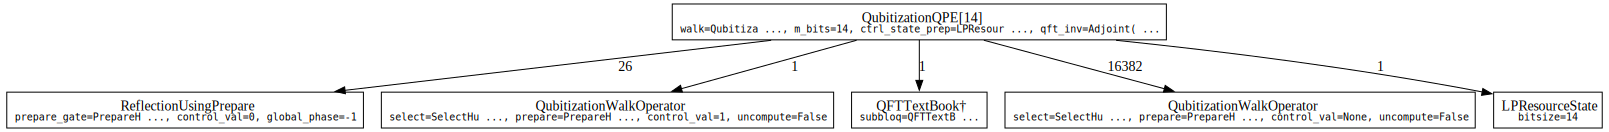

#### Counts totals:
 - `Adjoint(subbloq=QFTTextBook(bitsize=14, with_reverse=True))`: 1
 - `LPResourceState(bitsize=14)`: 1
 - `QubitizationWalkOperator(select=SelectHubbard(x_dim=2, y_dim=2, control_val=1), prepare=PrepareHubbard(x_dim=2, y_dim=2, t=2, mu=8), control_val=1, uncompute=False)`: 1
 - `QubitizationWalkOperator(select=SelectHubbard(x_dim=2, y_dim=2, control_val=None), prepare=PrepareHubbard(x_dim=2, y_dim=2, t=2, mu=8), control_val=None, uncompute=False)`: 16382
 - `ReflectionUsingPrepare(prepare_gate=PrepareHubbard(x_dim=2, y_dim=2, t=2, mu=8), control_val=0, global_phase=-1)`: 26

In [7]:
from qualtran.resource_counting.generalizers import ignore_split_join
qubitization_qpe_hubbard_model_small_g, qubitization_qpe_hubbard_model_small_sigma = qubitization_qpe_hubbard_model_small.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(qubitization_qpe_hubbard_model_small_g)
show_counts_sigma(qubitization_qpe_hubbard_model_small_sigma)